In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from os import path
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.linear_model import LinearRegression

labels = ["paiceHusk", "krovetz", "sStripping", "porter2", "lovins", "wikt", "none"]
collection_n_values = [1,2,4,8,16,32,64]
collection_sizes = [52342886, 26171443, 13085721, 6542860, 3271430, 1635715, 817857]

home_dir = "/home/katelyn/Documents/COSC490/Stemming"
data_dir_clueweb = path.join(home_dir, "Data/clueweb")
data_dir_wikt = path.join(home_dir, "Data/wikt")

MARKERS = ["o","^","s","*","d", "P", "X"]

### Preparing Data

In [2]:
df_list = list()

for n in collection_n_values:
   df = pd.read_csv(path.join(data_dir_clueweb,f"collectionSize/ndcg_{n}"), sep=" ")
   df_list.append(df)

data = pd.concat(df_list, ignore_index=True)

data_avg = data[data["qid"] == "amean"]
data = data.drop(data[data["qid"] == "amean"].index)


### Overall nDCG

In [3]:
best_nDCG = list()
for size in collection_sizes:
    selected_data = data_avg[data_avg["collectionSize"] == size]
    best_nDCG.append(selected_data["ndcg"].max())

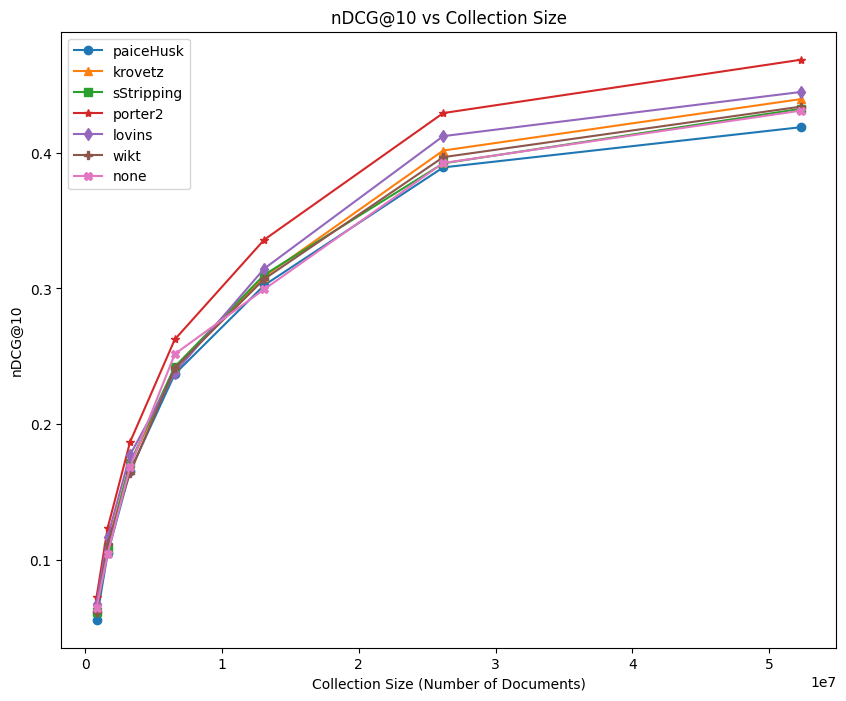

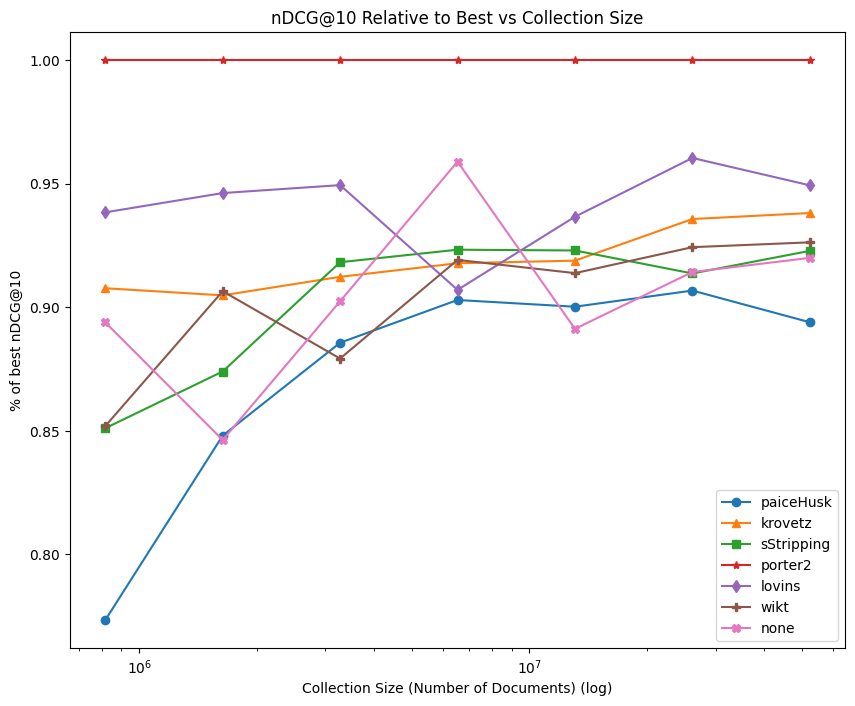

In [7]:
marker = itertools.cycle(MARKERS)

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = data_avg[data_avg["stemmer"] == stemmer]
    plt.plot(stemmer_data["collectionSize"], stemmer_data["ndcg"], marker=next(marker), label=stemmer)

plt.title("nDCG@10 vs Collection Size")
plt.xlabel("Collection Size (Number of Documents)")
plt.ylabel("nDCG@10")
plt.legend()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = data_avg[data_avg["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["ndcg"])/best_nDCG
    plt.plot(stemmer_data["collectionSize"], stemmer_values, marker=next(marker), label=stemmer)
    plt.xscale("log")

plt.title("nDCG@10 Relative to Best vs Collection Size")
plt.xlabel("Collection Size (Number of Documents) (log)")
plt.ylabel("% of best nDCG@10")
plt.legend()

### Linguistic Accuracy

In [13]:
ndcg_fmeasure = data_avg[data_avg["stemmer"] != "none"]
ndcg_fmeasure = ndcg_fmeasure[ndcg_fmeasure["stemmer"] != "wikt"]
averages = list()
for stemmer in labels[:-2]:
    fmeasures = np.loadtxt(path.join(data_dir_wikt,f"{stemmer}_cluster_fmeasures.csv"))
    averages.append(fmeasures.mean())
fmeasures = list()
for size in collection_sizes:
    fmeasures.extend(averages)
ndcg_fmeasure = ndcg_fmeasure.assign(fmeasure=fmeasures)

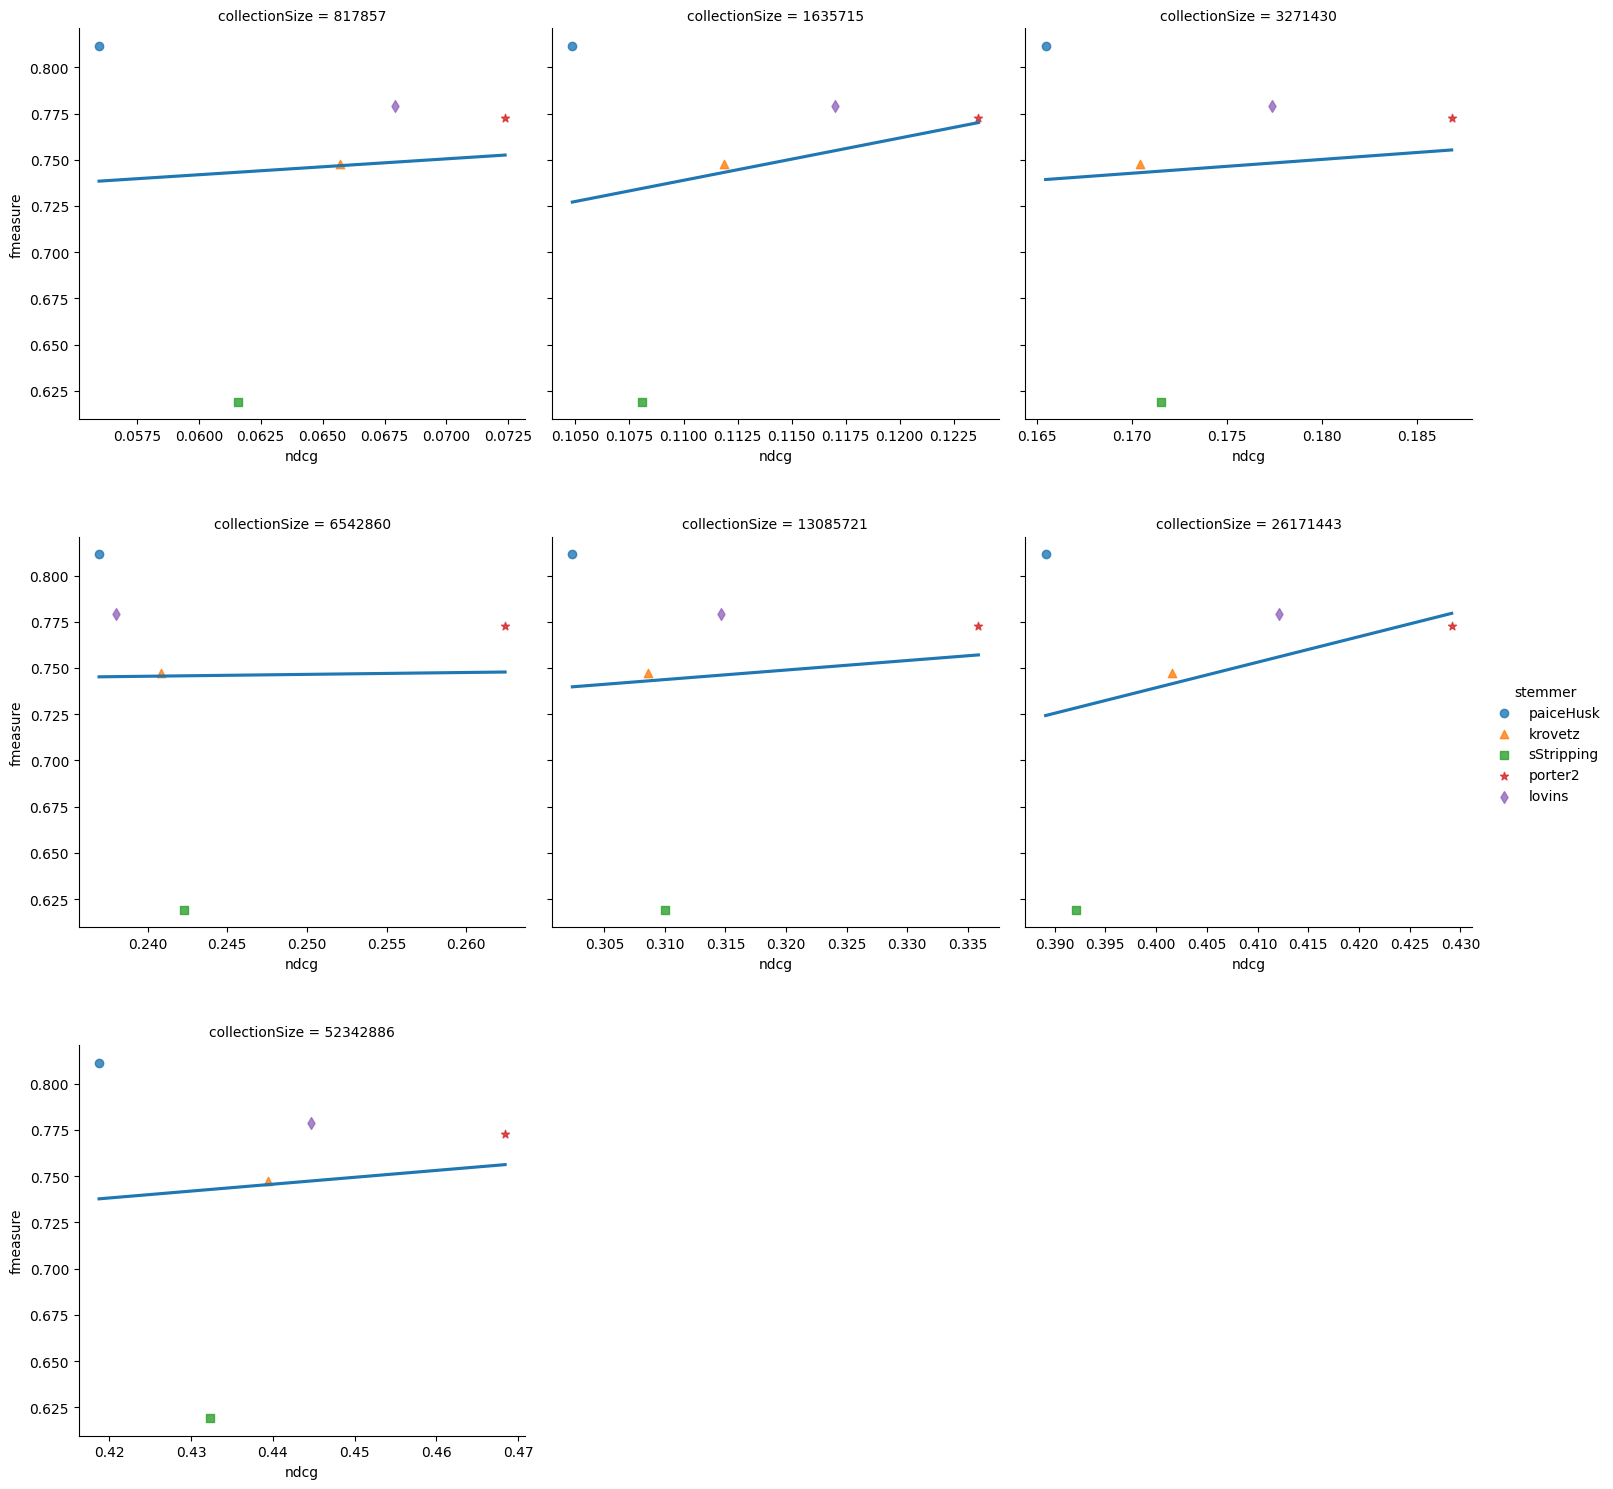

In [14]:
graph = sns.lmplot(ndcg_fmeasure, x="ndcg", y="fmeasure", hue="stemmer", markers=MARKERS[:-2], col="collectionSize", col_wrap=3, facet_kws={"sharex": False}, fit_reg=False)

for size, ax in zip(np.unique(data_avg["collectionSize"]), graph.axes):
    target_data = ndcg_fmeasure[ndcg_fmeasure["collectionSize"] == size]
    sns.regplot(target_data, x="ndcg", y="fmeasure", scatter=False, ci=None, ax=ax)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [16]:
print("size pearson-R p-value")
for size in reversed(collection_sizes):
    x = ndcg_fmeasure[ndcg_fmeasure["collectionSize"] == size]["ndcg"].to_numpy()
    y = ndcg_fmeasure[ndcg_fmeasure["collectionSize"] == size]["fmeasure"].to_numpy()
    print(f"{size} {stats.pearsonr(x,y).statistic:.3f} {stats.pearsonr(x,y).pvalue:.3f}")

size pearson-R p-value
817857 0.072 0.908
1635715 0.229 0.712
3271430 0.082 0.896
6542860 0.014 0.982
13085721 0.089 0.887
26171443 0.303 0.620
52342886 0.092 0.884


### Statistical Significance

In [6]:
#t-test between the porter2 stemmer (one of the best performing) and no stemming
print("size t-statistic p-value")
for size in reversed(collection_sizes):
    s = list()
    n = list()
    target_data = data[data["collectionSize"] == size]
    s = target_data[target_data["stemmer"] == "porter2"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"{size} {stats.ttest_rel(s,n).statistic:.4f} {stats.ttest_rel(s,n).pvalue:.4f}")

size t-statistic p-value
817857 1.1581 0.2496
1635715 1.9522 0.0537
3271430 1.8585 0.0661
6542860 0.9586 0.3401
13085721 2.5326 0.0129
26171443 2.4722 0.0151
52342886 2.1703 0.0324


In [12]:
#t-test between paiceHusk (one of the lowest performing) and none
print("size t-statistic p-value")
for size in reversed(collection_sizes):
    s = list()
    n = list()
    target_data = data[data["collectionSize"] == size]
    s = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"{size} {stats.ttest_rel(s,n).statistic:.4f} {stats.ttest_rel(s,n).pvalue:.4f}")

size t-statistic p-value
817857 -1.1474 0.2540
1635715 0.0189 0.9850
3271430 -0.2481 0.8046
6542860 -1.0278 0.3065
13085721 0.1865 0.8524
26171443 -0.1766 0.8602
52342886 -0.6123 0.5417


In [3]:
#t-test between porter2 and paiceHusk
print("size t-statistic p-value")
for size in reversed(collection_sizes):
    s = list()
    n = list()
    target_data = data[data["collectionSize"] == size]
    s = target_data[target_data["stemmer"] == "porter2"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"ndcg"].tolist()
    print(f"{size} {stats.ttest_rel(s,n).statistic:.4f} {stats.ttest_rel(s,n).pvalue:.4f}")

size t-statistic p-value
817857 2.3315 0.0218
1635715 2.3912 0.0187
3271430 2.1190 0.0366
6542860 2.1978 0.0303
13085721 2.1858 0.0312
26171443 2.1415 0.0347
52342886 2.6539 0.0093


In [11]:
#t-test between wikt and none
print("size t-statistic p-value")
for size in reversed(collection_sizes):
    s = list()
    n = list()
    target_data = data[data["collectionSize"] == size]
    s = target_data[target_data["stemmer"] == "wikt"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"{size} {stats.ttest_rel(s,n).statistic:.4f} {stats.ttest_rel(s,n).pvalue:.4f}")

size t-statistic p-value
817857 -0.6268 0.5322
1635715 0.7919 0.4303
3271430 -0.4132 0.6804
6542860 -0.9484 0.3452
13085721 0.6232 0.5346
26171443 0.2804 0.7798
52342886 0.1719 0.8639
